In [583]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
import warnings
from scipy.stats import chi2_contingency,kendalltau,pointbiserialr,fisher_exact
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix


In [521]:
warnings.filterwarnings("ignore")

In [522]:
df=pd.read_csv(r"D:\vijay\Imarticus\ML\new_pipeline\dataset/training.csv")

# This data has been collected from a drug company which has labelled data set of the drugs and 
# the parameters that effect it.
# Therefore, on the basis of the disease and the type of patient the drug is recommended.

In [523]:
df.columns=[x.lower() for x in df.columns]

In [613]:
df.isna().sum().sum().sum()

0

In [525]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          180 non-null    int64  
 1   sex          180 non-null    object 
 2   bp           180 non-null    object 
 3   cholesterol  180 non-null    object 
 4   na_to_k      180 non-null    float64
 5   drug         180 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 8.6+ KB


#### Age should be considered as discrete variable. Let us convert it to object type 

In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          180 non-null    object 
 1   sex          180 non-null    object 
 2   bp           180 non-null    object 
 3   cholesterol  180 non-null    object 
 4   na_to_k      180 non-null    float64
 5   drug         180 non-null    object 
dtypes: float64(1), object(5)
memory usage: 8.6+ KB


4 out of 5 independent variables are categorical in nature. Hence we need to use tree based models rather than logistic regression. 

####  Analysis on features

<AxesSubplot:xlabel='age', ylabel='count'>

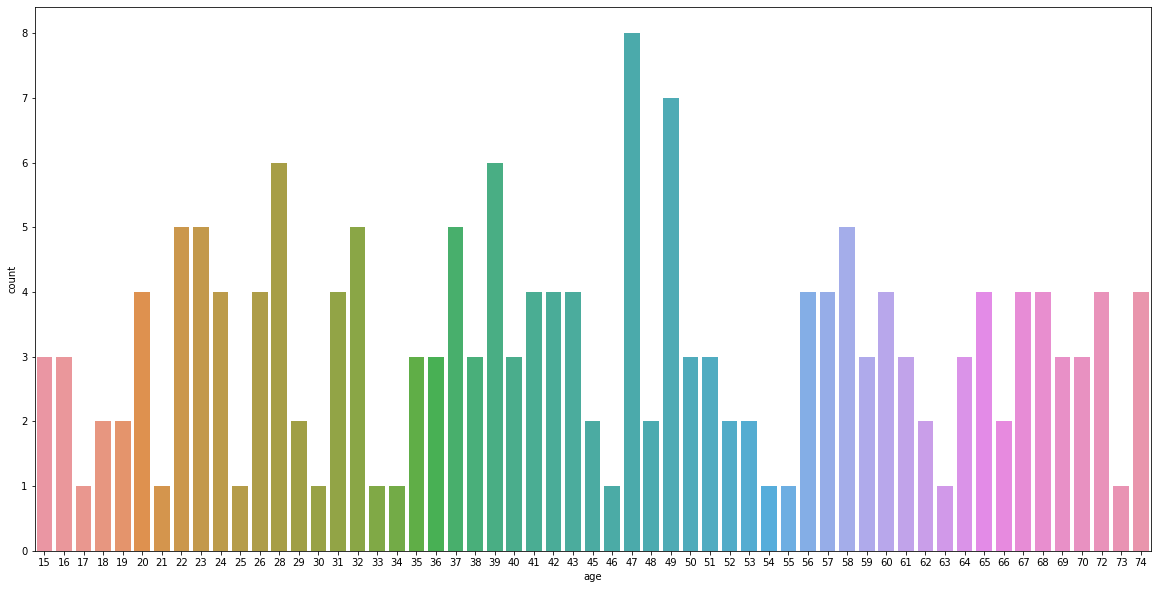

In [528]:
fig_0,axis_0=plt.subplots(figsize=(20,10))
sns.countplot(df["age"],ax=axis_0)

### We could see patients with age 47 is more in count

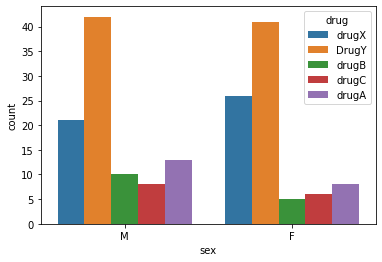

In [529]:
sns.countplot(df["sex"],hue="drug",data=df)
plt.show()


#  It is observed that drug Y is high in count for both male and female. 
# Also all drugs has been given to both Male and Female. We do not have any drug specific to any gender 

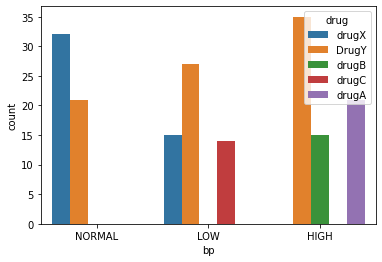

In [530]:
sns.countplot(df["bp"],hue="drug",data=df)
plt.show()

#  we could see that only drug x and drug y are given to patients with Normal BP level.
#  For patients with Low BP Drug x,y and drug c is given. 
#  For patients with High BP Drug y,b and drug A is given.
#  Drug B and Drug A seems to be given only to patients with High BP
#  Drug C is only given to patients with Low BP
#  Drug Y is tehe common drug given to all patients irrespective of BP level

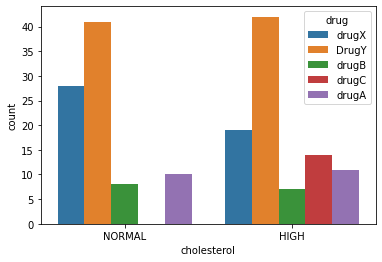

In [531]:
sns.countplot(df["cholesterol"],hue="drug",data=df)
plt.show()

# Drug C is not given to patients with Normal Cholesteral. 

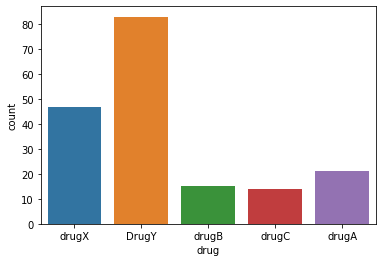

In [532]:
sns.countplot(df["drug"],data=df)
plt.show()

### Records for Drug Y is  is high. Hence the model will be biased towards drug Y. 


In [533]:
#  check if BP and drug given has dependency or not. We can use chi square test.
# H0: var are independent
# H1: Var are dependent
# alpha=0.05

chi2_contingency(pd.crosstab(df["bp"],df["drug"]))

#  Pvalue < 0.05 . Reject Null hypothesis. BP and Drug are dependent

(129.34330577546137,
 3.8703092265839824e-24,
 8,
 array([[32.73888889,  8.28333333,  5.91666667,  5.52222222, 18.53888889],
        [25.82222222,  6.53333333,  4.66666667,  4.35555556, 14.62222222],
        [24.43888889,  6.18333333,  4.41666667,  4.12222222, 13.83888889]]))

In [534]:
#  check if cholesterol and drug given has dependency or not. We can use chi square test.
# H0: var are independent
# H1: Var are dependent
# alpha=0.05

chi2_contingency(pd.crosstab(df["cholesterol"],df["drug"]))

#  Pvalue < 0.05 . Reject Null hypothesis. Cholesterol and Drug are dependent

(15.667146102489827,
 0.0034999259445441474,
 4,
 array([[42.88333333, 10.85      ,  7.75      ,  7.23333333, 24.28333333],
        [40.11666667, 10.15      ,  7.25      ,  6.76666667, 22.71666667]]))

In [535]:
df.groupby("drug")["sex"].value_counts(normalize=True)

drug   sex
DrugY  M      0.506024
       F      0.493976
drugA  M      0.619048
       F      0.380952
drugB  M      0.666667
       F      0.333333
drugC  M      0.571429
       F      0.428571
drugX  F      0.553191
       M      0.446809
Name: sex, dtype: float64

In [536]:
#  Check correlation between Sex and Drug. Since both the var are nominal we can use Kendal corr

print("Kendal coeff: ",kendalltau(df["sex"],df["drug"]))

print("Chi2 results",chi2_contingency(pd.crosstab(df["sex"],df["drug"])))

Kendal coeff:  KendalltauResult(correlation=-0.019320049826472754, pvalue=0.779009199300859)
Chi2 results (3.3378579733902165, 0.50295643481698, 4, array([[39.65555556, 10.03333333,  7.16666667,  6.68888889, 22.45555556],
       [43.34444444, 10.96666667,  7.83333333,  7.31111111, 24.54444444]]))


#### Both Kendal coeff and chi2 test proves that Gender has no corr with drug and they are not dependent. But we could see that there is a difference in proportion of  each drug given to patients based on sex.  Hence we can build models with and without sex column and check the performance.

In [537]:
# df.drop("sex",axis=1,inplace=True)

<AxesSubplot:xlabel='drug', ylabel='na_to_k'>

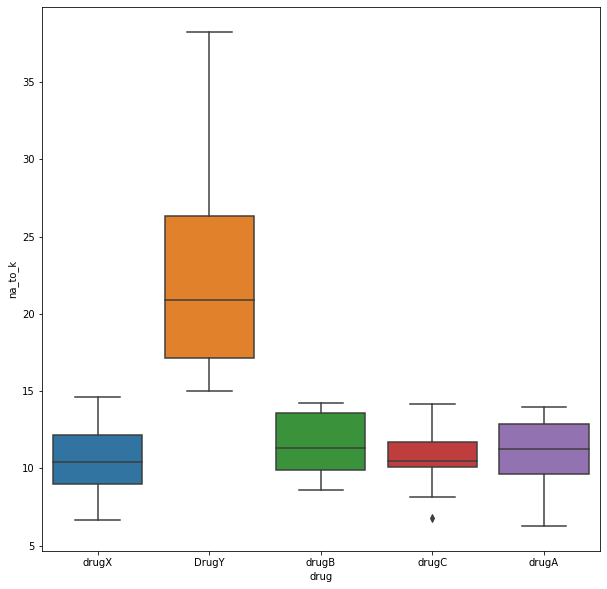

In [538]:
fig=plt.figure(figsize=(10,10))
axis_1=fig.add_subplot(1,1,1)
sns.boxplot(x=df["drug"],y=df["na_to_k"],ax=axis_1)

In [539]:
### We could see Median value of na_to_k is high for drugY. 
# It is Seen that for patients with high na_to_k drugY is given. Hence na_to_k column and drug seems to be  dependent. 



<AxesSubplot:xlabel='drug', ylabel='age'>

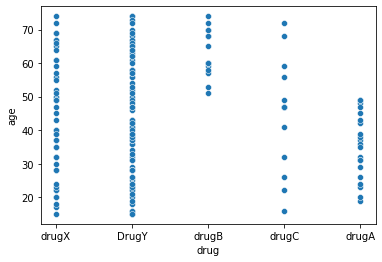

In [540]:
sns.scatterplot("drug","age",data=df)

In [541]:
###  We can observe that drug B is given to patients with high age  and drug A is given to patients who are younger. 
# Other 3 drugs are given to patients with all age group. Age plays a significant role i chosing the drug. 

In [542]:
df.columns

Index(['age', 'sex', 'bp', 'cholesterol', 'na_to_k', 'drug'], dtype='object')

In [543]:
bi_class=[]

for i in df.columns:
    if len(df[i].unique())==2:
        bi_class.append(i)

for i in bi_class:
    label_encode_obj= LabelEncoder().fit(df[i])
    with open(fr"D:\vijay\Imarticus\{i}_obj_encoder.pickle","wb") as s:
        pickle.dump(label_encode_obj,s)
    vars()[f"{i}_obj_encoder"]=label_encode_obj
    df[i]=label_encode_obj.transform(df[i])

In [544]:
df["drug"].unique()

array(['drugX', 'DrugY', 'drugB', 'drugC', 'drugA'], dtype=object)

In [545]:
def bp_encode(x):
    if x=="NORMAL":
        return 1
    elif x=="LOW":
        return 0
    elif x=="HIGH":
        return 2

def bp_decode(x):
    if x==1 :
        return "NORMAL"
    elif x==0:
        return "LOW"
    elif x==2:
        return "HIGH"

def drug_encode(x):
    if x=="drugA":
        return  0
    elif x=="drugB":
        return 1
    elif x=="drugC":
        return 2
    elif x=="drugX":
        return 3
    elif x=="DrugY":
        return 4

def drug_decode(x):
    if x==0:
        return  "drugA"
    elif x==1:
        return "drugB"
    elif x==2:
        return "drugC"
    elif x==3:
        return "drugX"
    elif x==4:
        return "DrugY"



In [546]:
df["bp"]=df["bp"].apply(bp_encode)

In [547]:
df["drug"]=df["drug"].apply(drug_encode)

In [551]:
df.head(1)

,age,sex,bp,cholesterol,na_to_k,drug
0,67,1,1,1,10.898,3


In [631]:
list (df["drug"].value_counts(normalize=True).sort_values())[0]>0.25


False

In [555]:
### Model buiding  

x=df.drop("drug",axis=1)
y=df.iloc[:,[-1]]

xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,stratify=y)

dt_1=DecisionTreeClassifier().fit(xtrain,ytrain)


In [560]:
dt_1.feature_importances_

array([0.13747954, 0.        , 0.27192645, 0.11456628, 0.47602773])

Feature "Sex"  has No Importance. 

In [562]:
dt_1_preds=dt_1.predict(xtest)

print("Decision tree 1 accuracy:",accuracy_score(ytest,dt_1_preds))


Decision tree 1 accuracy: 0.9814814814814815


In [567]:
dt_2=DecisionTreeClassifier().fit(xtrain.drop("sex",axis=1),ytrain)

In [569]:
dt_2_preds=dt_2.predict(xtest.drop("sex",axis=1))

print("Decision tree 1 accuracy:",accuracy_score(ytest,dt_2_preds))


Decision tree 1 accuracy: 0.9814814814814815


In [570]:
### We can build model without having feature sex because it has no  impact on target variable. 

In [582]:
ss=SVC().fit(xtrain,ytrain)
svc_preds=ss.predict(xtest)
print("Accuracy for SVC model",accuracy_score(ytest,svc_preds))

Accuracy for SVC model 0.6851851851851852


In [584]:
ss=SVC().fit(xtrain,ytrain)
svc_preds=ss.predict(xtest)
print("Accuracy for SVC model",accuracy_score(ytest,svc_preds))

Accuracy for SVC model 0.6851851851851852


In [634]:
log_reg=LogisticRegression().fit(xtrain,ytrain)
# log_reg_preds=log_reg.predict(xtest)
# print("Accuracy for Log_reg model",accuracy_score(ytest,log_reg_preds))

In [650]:
import os
for c_fold,folders,files in os.walk(r"D:\vijay\Imarticus\ML\new_pipeline\artifacts"):
    for i in files:
        print(i)

cholesterol_obj_encoder.pickle
DT_object.pickle
GLM_object.pickle
RF_object.pickle
sex_obj_encoder.pickle


In [609]:
mp={"GLM":{}}

def dis(b=0,a=0):
    print(a)

In [610]:
dis(**mp["GLM"])

0


In [654]:
from sklearn.model_selection import cross_val_score

cross_val_score(DecisionTreeClassifier(),xtrain,ytrain,cv=5)

array([1.  , 1.  , 0.96, 1.  , 0.96])

In [660]:
import numpy as np

import numpy as np
import pandas as pd
import statistics as ss

def confusion_matrix(ytrue,ypreds):
    if type(ytrue)!=np.ndarray:
        ytrue=ytrue.to_numpy().flatten()
    if type(ypreds)!=np.ndarray:
        ypreds=ypreds.to_numpy().flatten()
    unique_vals=list(np.unique(np.append(ytrue,ypreds)))
    unique_vals.sort()
    conf=np.zeros(shape=(len(unique_vals),len(unique_vals)))

    for i,k in zip(ytrue,ypreds):
        
        conf[unique_vals.index(i),unique_vals.index(k)]=conf[unique_vals.index(i),unique_vals.index(k)]+1

    return conf.astype(int)


    

def get_metrics(conf_matrix):
    vals=conf_matrix.shape[0]
    val_dict={}
    metrics_dict={}

    for i in range(vals):
        tp=conf_matrix[i,i].sum()
        tn=np.delete(np.delete(conf_matrix,i,axis=0),i,axis=1).sum()
        fp=np.delete(np.delete(conf_matrix,list(set(range(vals))-{i}),axis=1),i,axis=0).sum()
        fn=np.delete(np.delete(conf_matrix,list(set(range(vals))-{i}),axis=0),i,axis=1).sum()
        val_dict[i]={"TP":tp,"TN":tn,"FP":fp,"FN":fn}
        metrics_dict[i]={"accuracy":(tp+tn)/(tp+tn+fp+fn),"precision":tp/(tp+fp),"recall":tp/(tp+fn),
                    "f1_score":ss.harmonic_mean([(tp/(tp+fp)),(tp/(tp+fn))])}
    return val_dict,metrics_dict



In [664]:
cm=confusion_matrix(ytest,svc_preds)

In [675]:
get_metrics(cm)

({0: {'TP': 0, 'TN': 48, 'FP': 0, 'FN': 6},
  1: {'TP': 0, 'TN': 49, 'FP': 0, 'FN': 5},
  2: {'TP': 0, 'TN': 50, 'FP': 0, 'FN': 4},
  3: {'TP': 12, 'TN': 28, 'FP': 12, 'FN': 2},
  4: {'TP': 25, 'TN': 24, 'FP': 5, 'FN': 0}},
 {0: {'accuracy': 0.8888888888888888,
   'precision': nan,
   'recall': 0.0,
   'f1_score': nan},
  1: {'accuracy': 0.9074074074074074,
   'precision': nan,
   'recall': 0.0,
   'f1_score': nan},
  2: {'accuracy': 0.9259259259259259,
   'precision': nan,
   'recall': 0.0,
   'f1_score': nan},
  3: {'accuracy': 0.7407407407407407,
   'precision': 0.5,
   'recall': 0.8571428571428571,
   'f1_score': 0.631578947368421},
  4: {'accuracy': 0.9074074074074074,
   'precision': 0.8333333333333334,
   'recall': 1.0,
   'f1_score': 0.9090909090909091}})

In [681]:
import openpyxl
from pandas import ExcelWriter

In [683]:
# file_pointer=ExcelWriter("D:\vijay\Imarticus\ML")
pd.DataFrame(confusion_matrix(ytest,svc_preds))

,0,1,2,3,4
0,0,0,0,5,1
1,0,0,0,3,2
2,0,0,0,4,0
3,0,0,0,12,2
4,0,0,0,0,25


In [685]:
accuracy_score(["a","a","b","c"],["a","c","b","a"])

0.5

In [693]:
ss=pd.DataFrame([1,2,3])
ss

,0
0,1
1,2
2,3


In [694]:
pd.DataFrame(ss)

,0
0,1
1,2
2,3
